In [1]:
from collections import defaultdict
from functools import total_ordering
from math import erf
from statistics import NormalDist

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib notebook

In [2]:
years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
team_years_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")
events_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/events.csv")
matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/matches.csv")
team_matches_df = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_matches.csv")

In [3]:
SQRT2 = 2 ** 0.5

@total_ordering
class Normal:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    @staticmethod
    def add(n1, n2, corr):
        new_mu = n1.mu + n2.mu
        new_sigma = (n1.sigma ** 2 + n2.sigma ** 2 + 2 * corr * n1.sigma * n2.sigma) ** 0.5
        return Normal(new_mu, new_sigma)
    
    @staticmethod
    def sub(n1, n2, corr):
        new_mu = n1.mu - n2.mu
        new_sigma = (n1.sigma ** 2 + n2.sigma ** 2 - 2 * corr * n1.sigma * n2.sigma) ** 0.5
        return Normal(new_mu, new_sigma)
    
    def __rmul__(self, other):
        return Normal(other * self.mu, other * self.sigma)
    
    def __lt__(self, other):
        return self.mu < other.mu
    
    def win_prob(self):
        return 0.5 - 0.5 * erf(-self.mu / (self.sigma * SQRT2))
    
    def __repr__(self):
        return "Normal (" + str(round(self.mu, 4)) + ", " + str(round(self.sigma, 4)) + ")"

In [4]:
n1 = Normal(5, 5)
n2 = Normal(5, 5)
print(n1.win_prob())
print(Normal.add(n1, n2, 0))
print(Normal.add(n1, n2, 0.5))
print(Normal.add(n1, n2, 1))
print(Normal.sub(n1, n2, 1))

0.8413447460685428
Normal (10, 7.0711)
Normal (10, 8.6603)
Normal (10, 10.0)
Normal (0, 0.0)


In [5]:
class History:
    def __init__(self):
        self._history = []
        
    def history(self, name):
        return [x[name] for x in self._history]
    
    def mean(self):
        raise NotImplementedError
    
    def sd(self):
        raise NotImplementedError
        
    def record(self, obs):
        self._history.append({
            "x": len(self._history),
            "obs": obs,
            "mean": self.mean(),
            "sd": self.sd(),
        })
        
    @staticmethod
    def plot_history(objs):
        fig, ax = plt.subplots(figsize=(9, 6))
        colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
        for color, obj in zip(colors, objs):
            x = obj.history("x")
            scaled_x = [x_i / (len(x) - 1) for x_i in x]
            ax.scatter(scaled_x, obj.history("obs"), label="Observations")
            ax.plot(scaled_x, obj.history("mean"), label="Mean")
            ax.fill_between(
                scaled_x, 
                [x - 2 * y for x, y in zip(obj.history("mean"), obj.history("sd"))], 
                [x + 2 * y for x, y in zip(obj.history("mean"), obj.history("sd"))],
                color=color, 
                alpha=0.4, 
                label="CI"
            )
            
        ax.legend()
        ax.grid()
        fig.show()
        
    def end_mean(self):
        data = self.history("mean")
        if len(data) < 12:
            return self.mean()
        return sum(data[-5:]) / 5

In [6]:
class Rating(History):
    def __init__(self, prior_n, prior_mean, sd_func):
        super().__init__()
        self.mu = prior_mean
        self.n = prior_n
        self.sd_func = sd_func
        
        self.streaks = [0, 0]
        
    # TODO: handle negative x upstream
    def add(self, x, n=None):
        self.record(x)

        self.mu = (self.mu * self.n + x) / (self.n + 1)
        
        mean, sd = self.mean(), self.sd()
        z_score = abs(mean - x) / sd
        if z_score > 1.5:
            self.n -= round(2 * z_score) / 2
            
        self.streaks[0] = self.streaks[0] + 1 if x > mean else 0
        self.streaks[1] = self.streaks[1] + 1 if x < mean else 0
        long_streak = max(self.streaks)
        if long_streak > 1:
            self.n -= long_streak / 2
        
        self.n = min(3, max(1, self.n + 0.5))
        
    def mean(self):
        return self.mu
    
    def sd(self):
        return self.sd_func(self.mean())
    
    def end_mean(self):
        return super().end_mean()
    
    def __repr__(self):
        return "Rating (" + str(round(self.mean(), 2)) + ", " + str(round(self.sd(), 2)) + ")"

In [7]:
SD_CONST = 4.2
SD = 0.045

class SimpleTeam(Rating):
    def __init__(self, prior_n, prior_mean):
        super().__init__(prior_n, prior_mean, lambda x: SD_CONST + SD * x)
        
    def add(self, x):
        super().add(x)
        
    def __repr__(self):
        return "Simple Team (" + str(round(self.mean(), 2)) + ", " + str(round(self.sd(), 2)) + ")"
    
    
class FullTeam(History):
    def __init__(self, prior_n, prior_mean):
        super().__init__()
        self.auto = Rating(prior_n, 0.3 * prior_mean, lambda x: 0.3 * (SD_CONST + SD * x))
        self.teleop = Rating(prior_n, 0.4 * prior_mean, lambda x: 0.4 * (SD_CONST + SD * x))
        self.endgame = Rating(prior_n, 0.3 * prior_mean, lambda x: 0.3 * (SD_CONST + SD * x))
        
    def mean(self):
        return self.auto.mean() + self.teleop.mean() + self.endgame.mean()
    
    def sd(self):
        return SD_CONST + SD * self.mean()
    
    def add(self, a, t, e):
        self.record(a + t + e)
        self.auto.add(a)
        self.teleop.add(t)
        self.endgame.add(e)
        
    def end_mean(self):
        return super().end_mean()
    
    def __repr__(self):
        return "Full Team (" + str(round(self.mean(), 2)) + ", " + str(round(self.sd(), 2)) + ")"

In [8]:
t1 = SimpleTeam(prior_n=1, prior_mean=13)
print(t1)
t1.add(20)
print(t1)


t2 = FullTeam(prior_n=1, prior_mean=13)
print(t2)
t2.add(5, 10, 5)
print(t2)

Simple Team (13, 4.79)
Simple Team (16.5, 4.94)
Full Team (13.0, 4.79)
Full Team (16.5, 4.94)


In [9]:
event_matches_df = matches_df[(matches_df.year == 2022) & (matches_df.comp_level == "qm") & (matches_df.status == "Completed")].sort_values(by=["time"])

In [10]:
data = []

prior_n, prior_mean = 1, 13.8
simple_teams = defaultdict(lambda: SimpleTeam(prior_n=prior_n, prior_mean=prior_mean))
full_teams = defaultdict(lambda: FullTeam(prior_n=prior_n, prior_mean=prior_mean))
for _, t in team_years_df[(team_years_df.year == 2022)].iterrows():
    team, opr = t.team, t.opr_start
    simple_teams[team] = SimpleTeam(prior_n=prior_n, prior_mean=opr)
    full_teams[team] = FullTeam(prior_n=prior_n, prior_mean=opr)

count, acc, mse = 0, 0, 0
event_count, event_acc, event_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    red_teams = [int(x) for x in match.red.split(",")]
    blue_teams = [int(x) for x in match.blue.split(",")]
    
    model = simple_teams
    red_means = [model[t].mean() for t in red_teams]
    red_sds = [model[t].sd() for t in red_teams]
    red_distrib = Normal(sum(red_means), sum(red_sds))
    blue_means = [model[t].mean() for t in blue_teams]
    blue_sds = [model[t].sd() for t in blue_teams]
    blue_distrib = Normal(sum(blue_means), sum(blue_sds))
    win_prob = Normal.sub(red_distrib, blue_distrib, 0).win_prob()
    
    data.append({
        "red_1": red_means[0],
        "red_2": red_means[1],
        "red_3": red_means[2],
        "red_pred": red_distrib.mu,
        "red_sd": red_distrib.sigma,
        "red_actual": match.red_no_fouls,
        "blue_1": blue_means[0],
        "blue_2": blue_means[1],
        "blue_3": blue_means[2],
        "blue_pred": blue_distrib.mu,
        "blue_sd": blue_distrib.sigma,
        "blue_actual": match.blue_no_fouls,
        "win_pred": win_prob,
        "win_actual": match.red_score > match.blue_score,
    })
    
    # win_prob = (win_prob + match.elo_win_prob) / 2
    
    mle_weight = 0.5
    for teams, actual in [(red_teams, match.red_no_fouls), (blue_teams, match.blue_no_fouls)]:
        means, sds = [simple_teams[t].mean() for t in teams], [simple_teams[t].sd() for t in teams]
        pred, variance = sum(means), sum([sd ** 2 for sd in sds])
        for team, mean, sd in zip(teams, means, sds):
            contrib1 = mean + 1 / 3 * (actual - pred)
            contrib2 = mean + sd ** 2 / variance * (actual - pred)
            simple_teams[team].add((1 - mle_weight) * contrib1 + mle_weight * contrib2)
            
    contribs = defaultdict(list)
    for teams, get_mean, get_sd, actual in [
        (red_teams, lambda t: t.auto.mean(), lambda t: t.auto.sd(), match.red_auto),
        (red_teams, lambda t: t.teleop.mean(), lambda t: t.teleop.sd(), match.red_teleop),
        (red_teams, lambda t: t.endgame.mean(), lambda t: t.endgame.sd(), match.red_endgame),
        (blue_teams, lambda t: t.auto.mean(), lambda t: t.auto.sd(), match.blue_auto),
        (blue_teams, lambda t: t.teleop.mean(), lambda t: t.teleop.sd(), match.blue_teleop),
        (blue_teams, lambda t: t.endgame.mean(), lambda t: t.endgame.sd(), match.blue_endgame),
    ]:
        means, sds = [get_mean(full_teams[t]) for t in teams], [get_sd(full_teams[t]) for t in teams]
        pred, variance = sum(means), sum([sd ** 2 for sd in sds])
        for team, mean, sd in zip(teams, means, sds):
            contrib1 = mean + 1 / 3 * (actual - pred)
            contrib2 = mean + sd ** 2 / variance * (actual - pred)
            contribs[team].append((1 - mle_weight) * contrib1 + mle_weight * contrib2)
            
    for t in contribs:
        full_teams[t].add(*contribs[t])
        
    if not match.playoff:
        count += 1
        acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"] and not match.playoff:
        # print(match.key)
        # print(red_teams, blue_teams)
        # print(red_total_distrib, blue_total_distrib, win_prob)
        # print(match.red_score, match.blue_score)
        # print()
        event_count += 1
        event_acc += (win_prob > 0.5 and match.red_score > match.blue_score) or (win_prob < 0.5 and match.red_score < match.blue_score)
        event_mse += (1 - win_prob) ** 2 if match.red_score > match.blue_score else win_prob ** 2  
    
print(count, acc / count, mse / count)
print(event_count, event_acc / event_count, event_mse / event_count)

12048 0.7597941567065073 0.15608252504472697
756 0.7592592592592593 0.1516447650844683


In [11]:
elo_count, elo_acc, elo_mse = 0, 0, 0
event_elo_count, event_elo_acc, event_elo_mse = 0, 0, 0
for _, match in event_matches_df.iterrows():
    elo_win_prob = match.mix_win_prob
    elo_count += 1
    elo_acc += (elo_win_prob > 0.5 and match.red_score > match.blue_score) or (elo_win_prob < 0.5 and match.red_score < match.blue_score)
    elo_mse += (1 - elo_win_prob) ** 2 if match.red_score > match.blue_score else elo_win_prob ** 2
    
    if match.event in ["2022carv", "2022gal", "2022hop", "2022new", "2022roe", "2022tur"] and not match.playoff:
        event_elo_count += 1
        event_elo_acc += (elo_win_prob > 0.5 and match.red_score > match.blue_score) or (elo_win_prob < 0.5 and match.red_score < match.blue_score)
        event_elo_mse += (1 - elo_win_prob) ** 2 if match.red_score > match.blue_score else elo_win_prob ** 2
    
    
print(elo_count, elo_acc / elo_count, elo_mse / elo_count)
print(event_elo_count, event_elo_acc / event_elo_count, event_elo_mse / event_elo_count)

12048 0.7674302788844621 0.15662204276311392
756 0.7791005291005291 0.1448736604365079


Full Team (24.33, 5.3)


<IPython.core.display.Javascript object>


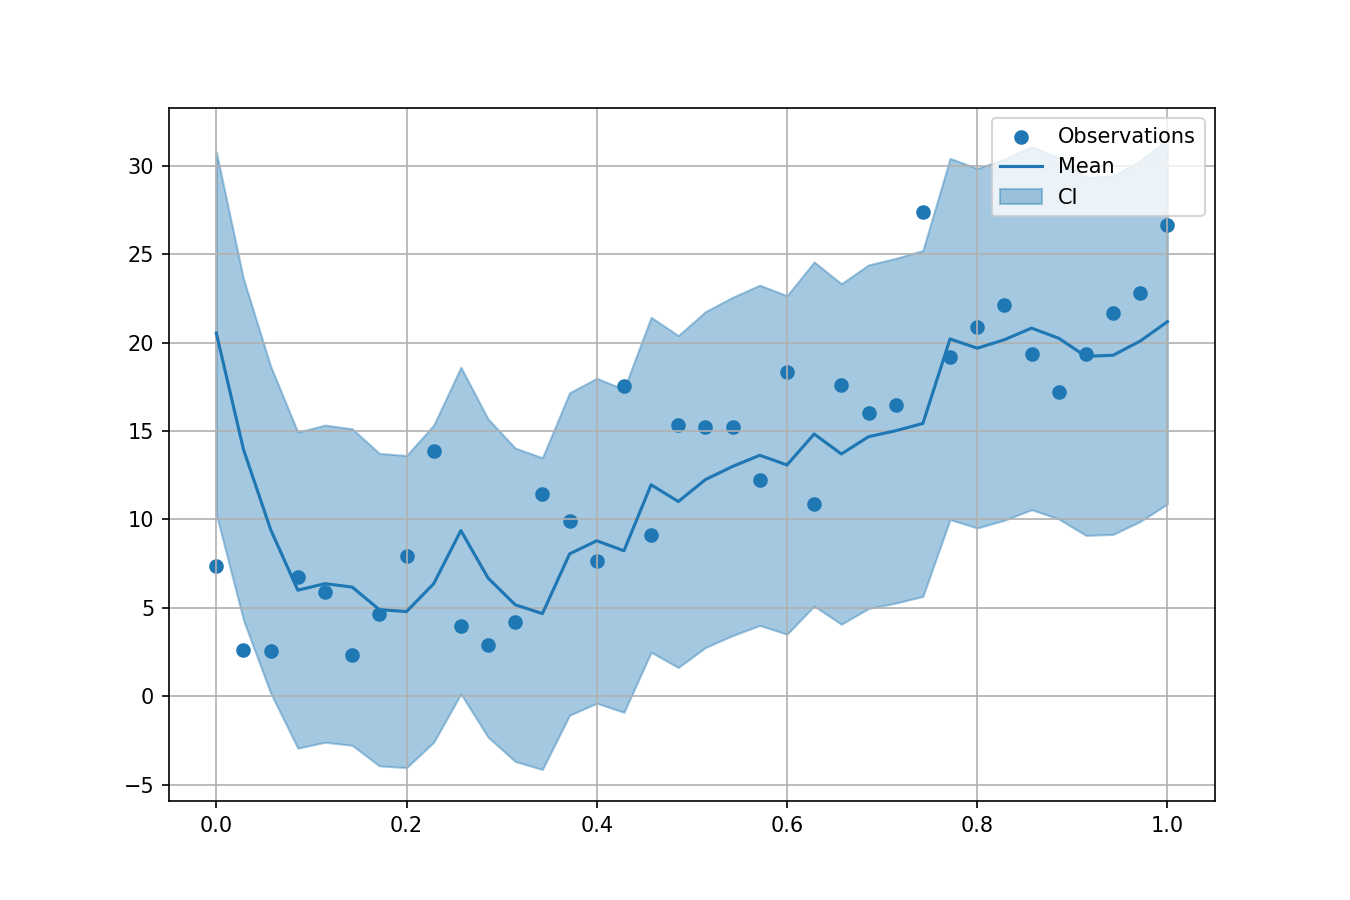

In [13]:
t = 5511

print(full_teams[t])
History.plot_history([simple_teams[t]])

<IPython.core.display.Javascript object>


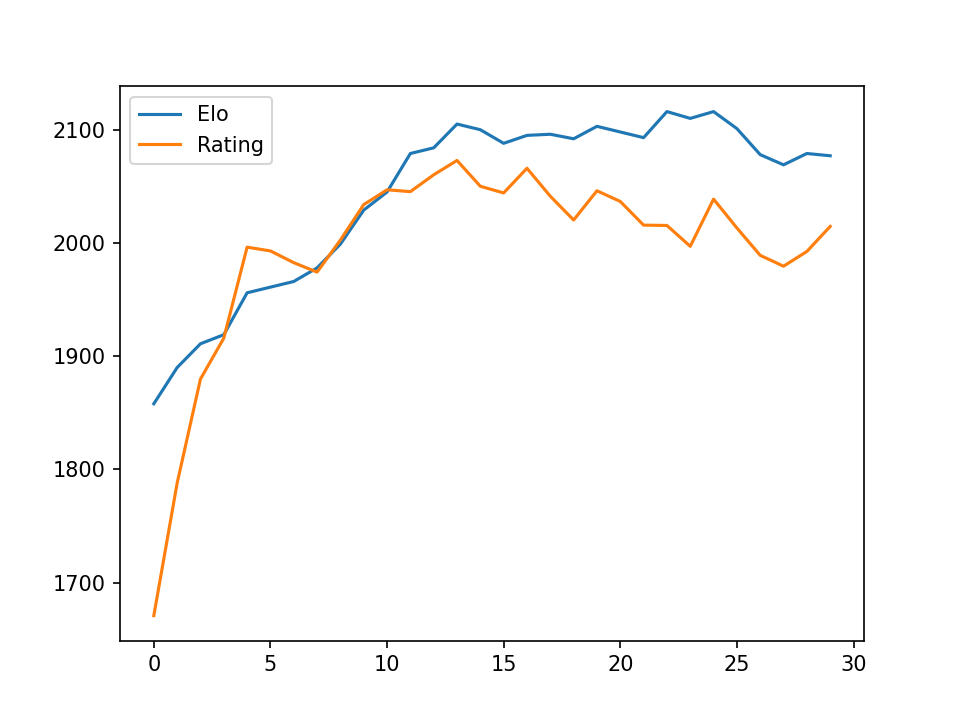

In [16]:
team = 254

fig, ax = plt.subplots()
elo = team_matches_df[(team_matches_df.year == 2022) & (team_matches_df.team == team) & (team_matches_df.playoff == False)].sort_values(by=["time"]).elo
x = [i for i in range(elo.shape[0])]
ax.plot(x, elo, label="Elo")
rating = simple_teams[team].history("mean")
ax.plot(x, [1361 + 9.25 * r for r in rating], color="tab:orange", label="Rating")
ax.legend()
fig.show()

In [17]:
best_teams = sorted(full_teams.items(), key=lambda x: -x[1].end_mean())[:10]

for team, rating in best_teams:
    print(team, "\t", rating.end_mean())

1678 	 82.15114519180453
254 	 67.44557314912288
67 	 67.41374954344906
1577 	 66.34273750827913
1323 	 65.42685564981586
118 	 62.7290757590773
1690 	 62.24024923864221
1619 	 60.51223797320597
27 	 60.38871958879956
176 	 59.45928839689422


<IPython.core.display.Javascript object>


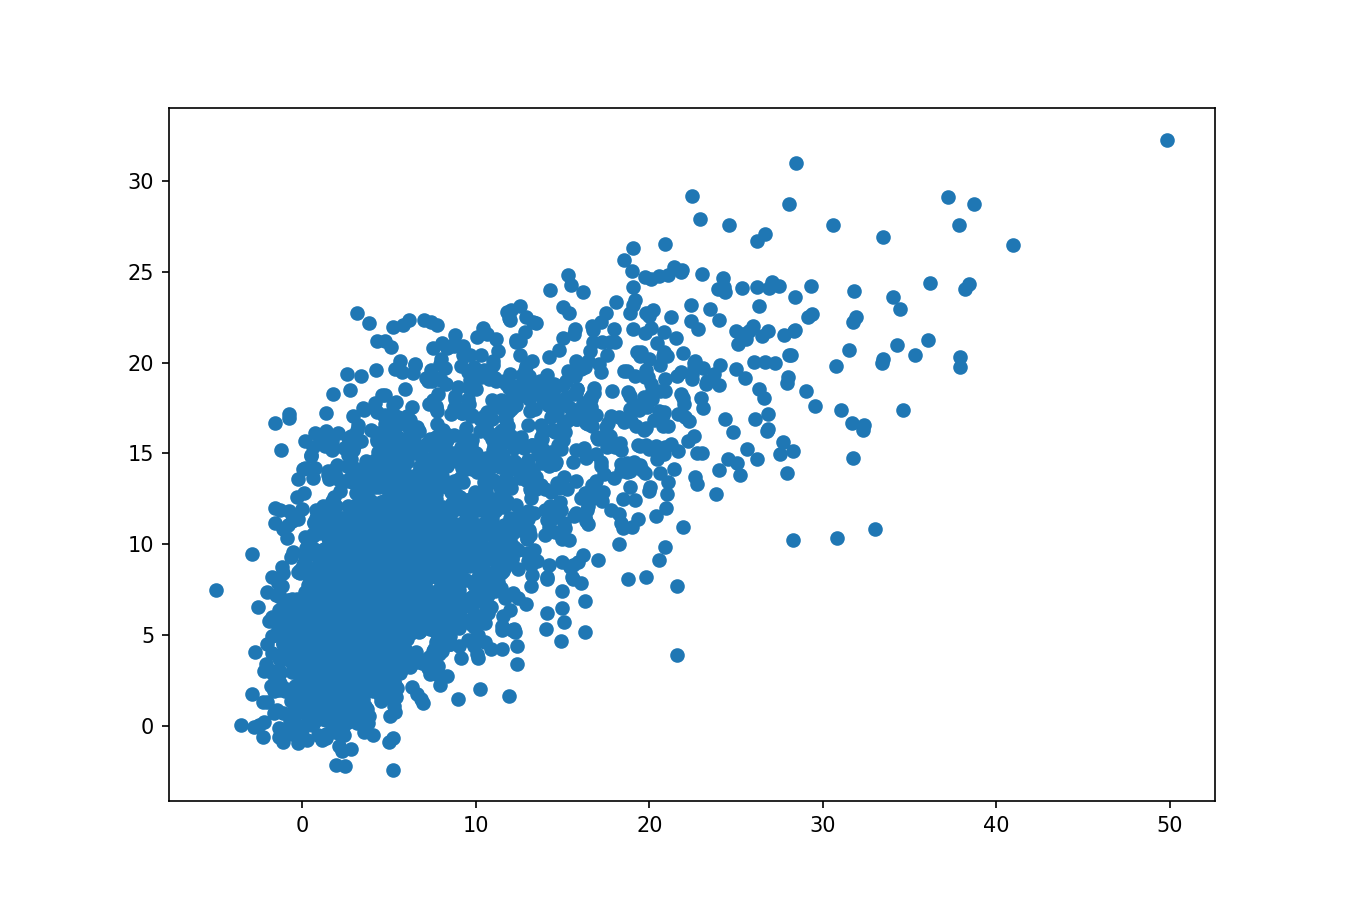

In [18]:
auto_list = [x.auto.end_mean() for x in full_teams.values()]
teleop_list = [x.teleop.end_mean() for x in full_teams.values()]
auto_teleop_list = [x + y for x, y in zip(auto_list, teleop_list)]
endgame_list = [x.endgame.end_mean() for x in full_teams.values()]
auto_endgame_list = [x + y for x, y in zip(auto_list, endgame_list)]
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(teleop_list, auto_endgame_list)
fig.show()

## Post Analysis

In [19]:
data_df = pd.DataFrame(data)
data_df.head()

,red_1,red_2,red_3,red_pred,red_sd,red_actual,blue_1,blue_2,blue_3,blue_pred,blue_sd,blue_actual,win_pred,win_actual
0,11.27,13.61,4.81,29.69,13.93605,49.0,7.94,14.42,10.77,33.13,14.09085,6.0,0.431099,True
1,11.77,19.31,11.12,42.20,14.49900,13.0,11.52,10.00,10.41,31.93,14.03685,23.0,0.694591,False
2,8.19,17.03,18.73,43.95,14.57775,40.0,13.80,12.58,10.09,36.47,14.24115,2.0,0.643204,True
3,30.65,18.02,17.60,66.27,15.58215,26.0,26.03,11.37,13.80,51.20,14.90400,9.0,0.757694,True
4,13.56,14.71,15.37,43.64,14.56380,16.0,16.06,13.80,14.47,44.33,14.59485,12.0,0.486652,True


### Calibration

<IPython.core.display.Javascript object>


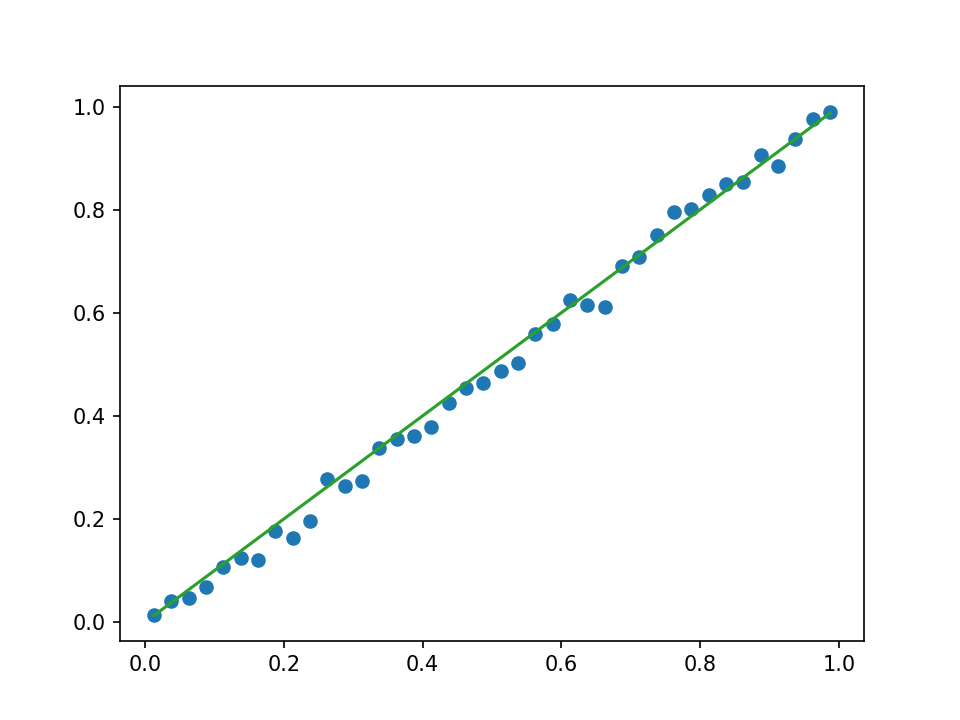

In [20]:
fig, ax = plt.subplots()

x, y = [], []
n = 40
temp_df = data_df
for i in range(n):
    percent = i / n
    subset_df = temp_df[(temp_df.win_pred > percent) & (temp_df.win_pred < percent + 1 / n)]
    actual_percent = subset_df.win_actual.mean()
    x, y = x + [percent + 1 / n /2], y + [actual_percent]
    
x, y = np.array(x), np.array(y)
ax.scatter(x, y)
ax.plot(x, x, color="tab:green")
fig.show()

<IPython.core.display.Javascript object>


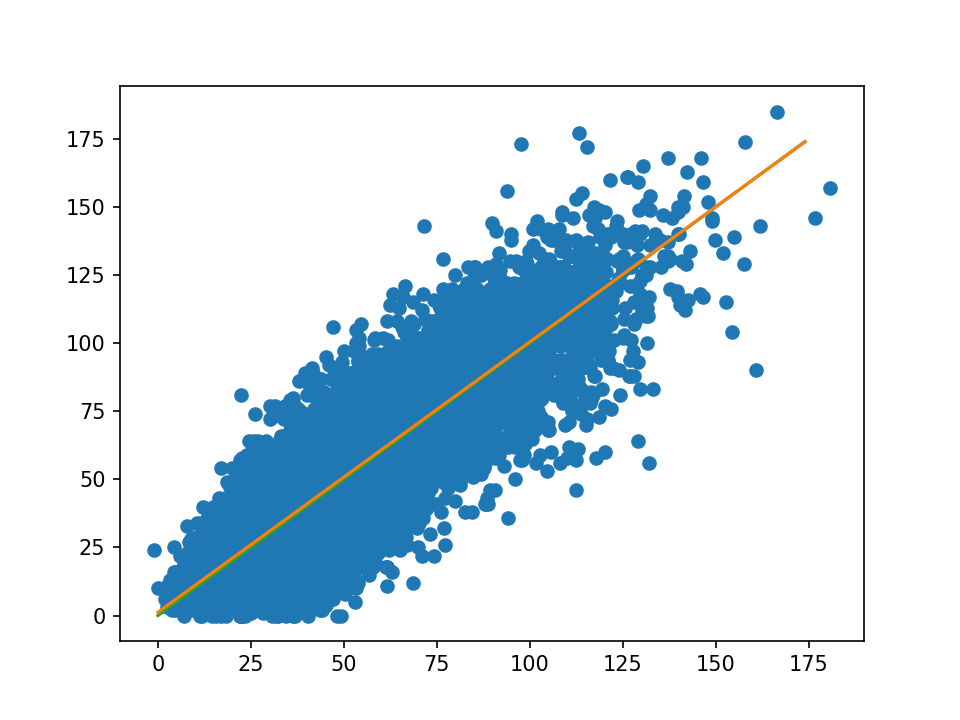

0.9921631902636507 1.225016529983652


In [21]:
fig, ax = plt.subplots()
ax.scatter(data_df.red_pred, data_df.red_actual)
m, b = np.polyfit(data_df.red_pred, data_df.red_actual, 1)
print(m, b)
ax.plot([x for x in range(175)], [x for x in range(175)], color="tab:green")
ax.plot([x for x in range(175)], [m * x + b for x in range(175)], color="tab:orange")
fig.show()

<IPython.core.display.Javascript object>


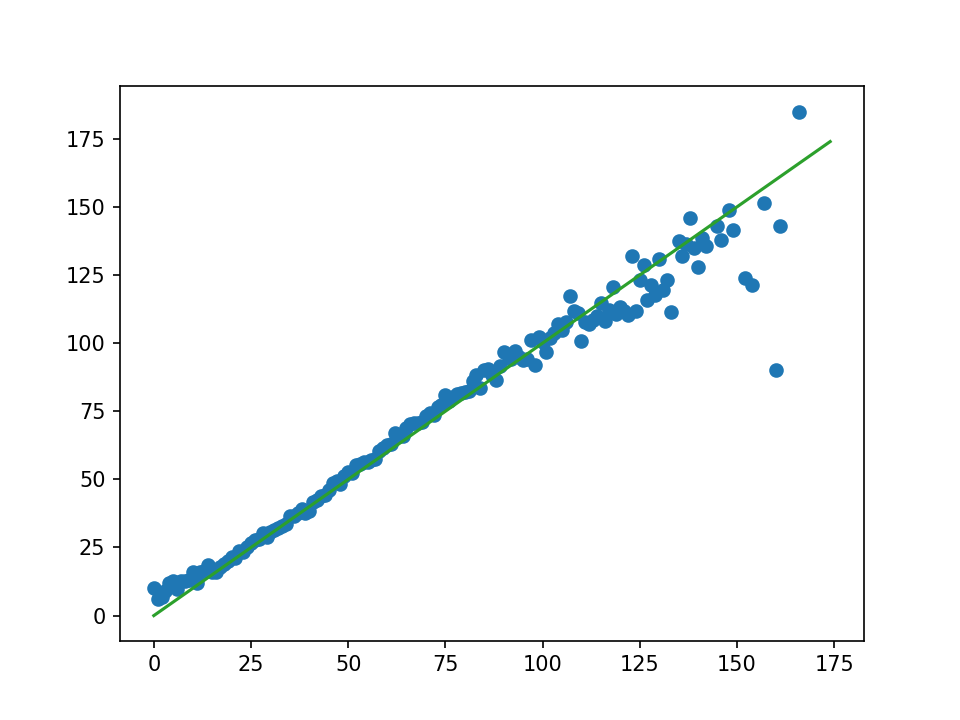

In [22]:
fig, ax = plt.subplots()

x, y = [], []
temp_df = data_df
for i in range(175):
    subset_df = temp_df[(temp_df.red_pred > i) & (temp_df.red_pred < i + 1)]
    actual = subset_df.red_actual.mean()
    x, y = x + [i], y + [actual]
    
x, y = np.array(x), np.array(y)
ax.scatter(x, y)
ax.plot(x, x, color="tab:green")
fig.show()

### Standard Deviation Tuning

<IPython.core.display.Javascript object>


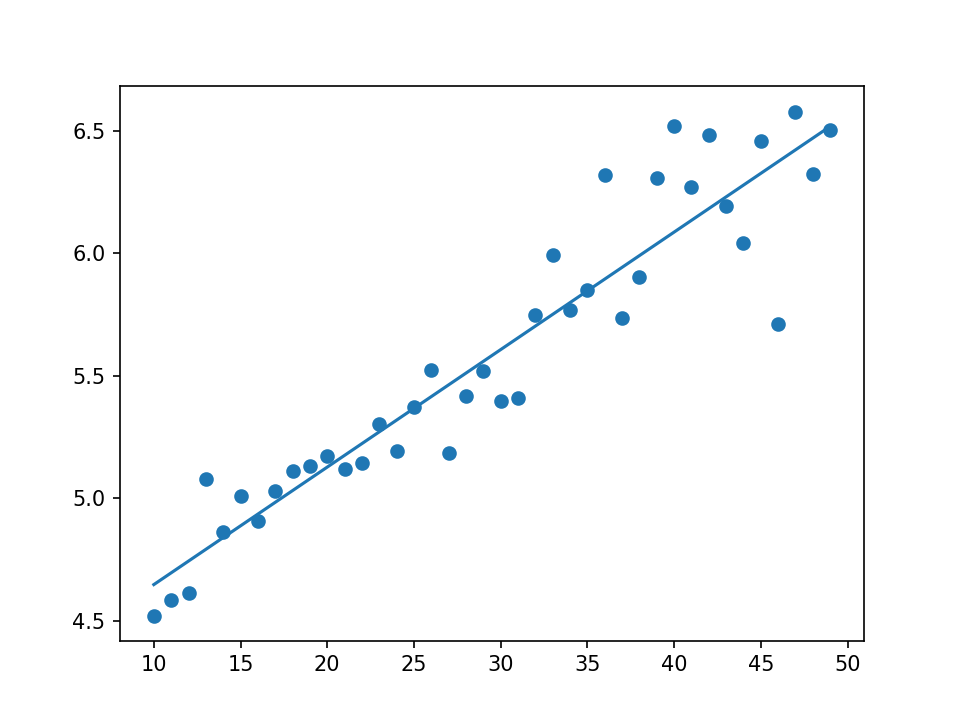

0.04799827266702086 4.166927626820987


In [23]:
xs, ys = [], []

for i in range(10, 50):
    distrib = []
    for team in full_teams:
        for obs, mean in zip(full_teams[team].history("obs"), full_teams[team].history("mean")):
            if mean > i and mean < i + 1:
                distrib.append(obs)
                
    if len(distrib) > 0:
        norm = NormalDist.from_samples(distrib)
        xs.append(i)
        ys.append(norm.stdev)

xs, ys = np.array(xs), np.array(ys)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
a, b = np.polyfit(xs, ys, 1)
ax.plot(xs, a * xs + b)
print(a, b)
fig.show()

<IPython.core.display.Javascript object>


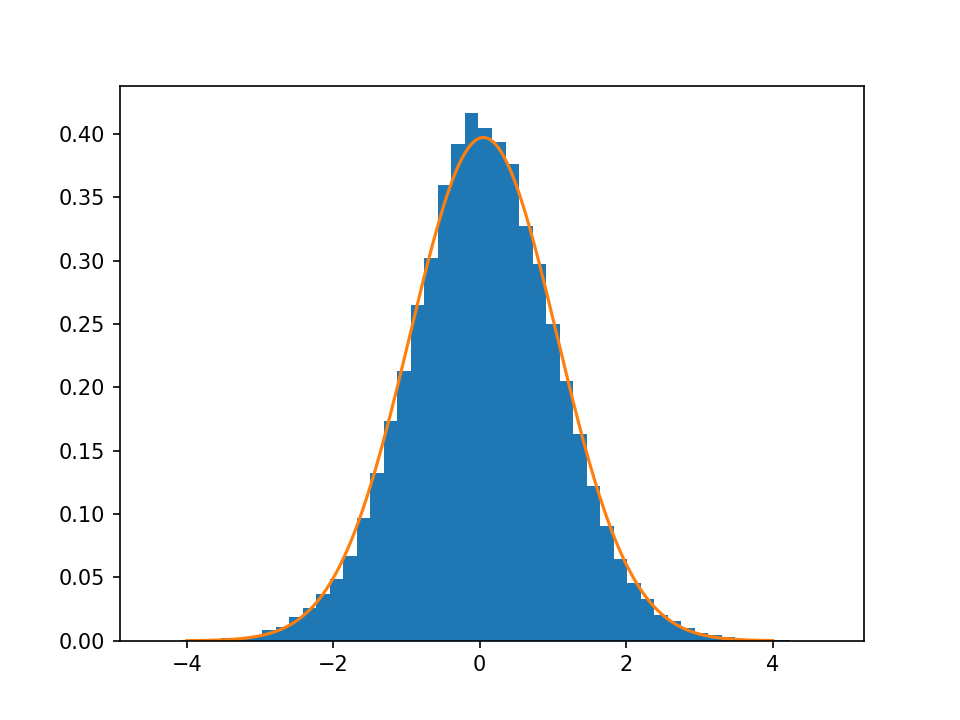

NormalDist(mu=0.05120286968025577, sigma=1.0046931828175851)


In [24]:
distrib = []
for team in full_teams:
    for obs, mean in zip(full_teams[team].history("obs"), full_teams[team].history("mean")):
        distrib.append((obs - mean) / (0.05 * mean + 4))
            
fig, ax = plt.subplots()
y_actual = ax.hist(distrib, bins=50, density=True)
norm = NormalDist.from_samples(distrib)
print(norm)

x = np.linspace(-4, 4, 1000)
y = 1 / np.sqrt(2 * np.pi) / norm.stdev * np.exp(-1/2*((x-norm.mean)/norm.stdev)**2)
ax.plot(x, y)
fig.show()

In [ ]:
# TODO:
# 1. data can be noisy, implementing moving average helps in worlds, not before (maybe teams need to update)
# 2. better way of setting starting opr using knowledge about skill variance
# 3. Incorporate elimination matches, maybe with half weighting
# 4. Investigate changing self.n differently (simpler?), reducing before new event
# 5. Create Python class for metrics, slice and dice differently for new insights
# 6. nonlinearity, different weights, defense factor, etc.